/home/maousi/miniconda3/envs/ml/lib/python3.8/site-packages/ipypublish/scripts/nb_setup.py:226: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  mpl.rcParams[key] = val
/home/maousi/miniconda3/envs/ml/lib/python3.8/site-packages/ipypublish/scripts/nb_setup.py:226: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  mpl.rcParams[key] = val
/home/maousi/miniconda3/envs/ml/lib/python3.8/site-packages/ipypublish/scripts/nb_setup.py:226: MatplotlibDeprecationWarning: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  mpl.rcParams[key] = val
/home/maousi/miniconda3/envs/ml/lib/python3.8/site-packages/ipypublish/scripts/nb_setup.py:226: MatplotlibDeprecationWa

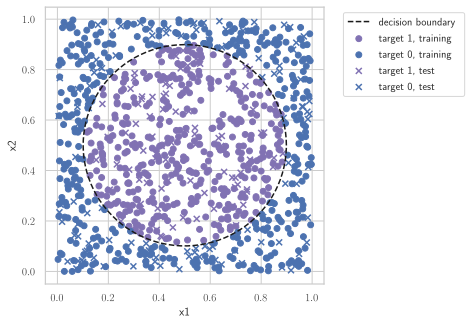

In [2]:
import argparse
import json
from math import pi, sqrt
from typing import Union, List

from torch import empty, tensor, linspace, vstack, set_grad_enabled

import seaborn as sns
from ipypublish import nb_setup
plt = nb_setup.setup_matplotlib(print_errors=True)
sns.set(style='whitegrid')

# --- Our custom modules
import function as F
from module import LinearLayer, Sequential
from training import Dataset, train_SGD, kfold_cv


# --- Disable globally autograd
set_grad_enabled(False)


# --------------------------------------------------------- #
#                           UTILS                           #
# --------------------------------------------------------- #

def pretty_print_section(section: str) -> None:
    """Pretty print a header in order to make the script output look nice"""
    print(f'\n# ------ {section.upper()}\n')


def acc(yhat, y):
    """Computes accuracy"""
    return (yhat.round().clip(0, 1) == y).to(float).mean().item()


def build_model(activation_fun: F.Function, xavier_init: bool = True, model_name: str = None, clip=False):
    """Build a deep neural network with a fixed architecture:
    2 input neurons, 3 hidden layers of 25 neurons each, 1 output unit"""
    model = Sequential(
        LinearLayer(2, 25, xavier_init=xavier_init),
        activation_fun(),
        LinearLayer(25, 25, xavier_init=xavier_init),
        activation_fun(),
        LinearLayer(25, 25, xavier_init=xavier_init),
        activation_fun(),
        LinearLayer(25, 1, xavier_init=xavier_init)
    )
    if clip:
        model.add_layer(F.Sigmoid())
    model._name = model_name
    return model


def train_and_test(model: Sequential, train_set: Dataset, test_set: Dataset,
                   loss_fun: F.Function, lr: Union[float, List[float]], epochs: int):
    # Train
    log = train_SGD(
        train_set,
        model,
        loss_fun,
        lr=lr,
        epochs=epochs
    )
    # Predict
    yhat_train, ytrain = tensor([[model(x).item(), y.item()] for x, y in train_set]).T
    yhat_test, ytest = tensor([[model(x).item(), y.item()] for x, y in test_set]).T
    # Performance evaluation
    acc_train = acc(yhat_train, ytrain)
    acc_test = acc(yhat_test, ytest)

    return log, acc_train, acc_test


# -------------------------------------------------------- #
#                    DATASET GENERATION                    #
# -------------------------------------------------------- #

# --- Generate data
# 1000 2D points uniformly distributed in [0,1]^2
n = 1000
d = 2
X = empty(n, d)
X.uniform_()

# --- Generate target
# Compute distance of each point from (0.5, 0.5)
center = tensor([0.5, 0.5])
squared_dist = ((X - center)**2).sum(axis=1)
radius_squared = 1 / 2 / pi
target = (squared_dist < radius_squared) * 1
# Decision boundary (for plotting)
angles = linspace(0., 2. * pi, 200)
decision_bdry_true = vstack([angles.cos(), angles.sin()]).T * sqrt(radius_squared) + center

# --- Data splitting - Training & test sets
# Important note: we don't need to shuffle the data, as this each sample is already random
train_ratio = 0.8
split_point = int(train_ratio * n)
xtrain, xtest = X[:split_point], X[split_point:]
ytrain, ytest = target[:split_point], target[split_point:]


plt.figure(figsize=(5, 5))
# --- Plot dataset
plt.scatter(xtrain[ytrain == 1, 0], xtrain[ytrain == 1, 1], marker='o', c='m', label='target 1, training')
plt.scatter(xtrain[ytrain == 0, 0], xtrain[ytrain == 0, 1], marker='o', c='b', label='target 0, training')
plt.scatter(xtest[ytest == 1, 0], xtest[ytest == 1, 1], marker='x', c='m', label='target 1, test')
plt.scatter(xtest[ytest == 0, 0], xtest[ytest == 0, 1], marker='x', c='b', label='target 0, test')

# --- Plot decision boundaries
plt.plot(decision_bdry_true[:, 0], decision_bdry_true[:, 1], 'k--', label='decision boundary')

# --- Labeling
plt.xlabel('x1')
plt.ylabel('x2')
legend = plt.legend(bbox_to_anchor=(1.05, 1))

plt.savefig('fig_dataset.pdf', bbox_inches='tight')
plt.show()

# --- Data normalization
mu, std = xtrain.mean(0), xtrain.std(0)
xtrain = (xtrain - mu) / std
xtest  = (xtest  - mu) / std



# ------ MODELS

Sequential(FC1(2, 25), relu2, FC3(25, 25), relu4, FC5(25, 25), relu6, FC7(25, 1))
Sequential(FC1(2, 25), relu2, FC3(25, 25), relu4, FC5(25, 25), relu6, FC7(25, 1), sigmoid)
Sequential(FC1(2, 25), tanh2, FC3(25, 25), tanh4, FC5(25, 25), tanh6, FC7(25, 1))
Sequential(FC1(2, 25), tanh2, FC3(25, 25), tanh4, FC5(25, 25), tanh6, FC7(25, 1), sigmoid)
Sequential(FC1(2, 25), sigmoid2, FC3(25, 25), sigmoid4, FC5(25, 25), sigmoid6, FC7(25, 1))
Sequential(FC1(2, 25), sigmoid2, FC3(25, 25), sigmoid4, FC5(25, 25), sigmoid6, FC7(25, 1), sigmoid)

# ------ TRAINING

model relu	epochs: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 
model relu clipped	epochs: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 
model tanh	epochs: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 
model tanh clipped	epochs: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 
model

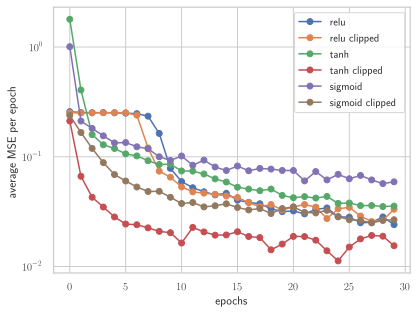


# ------ PERFORMANCE EVALUATION

                     Train accuracy     Test accuracy
relu                 0.975				0.975
relu clipped         0.936				0.935
tanh                 0.981				0.94
tanh clipped         0.981				0.975
sigmoid              0.963				0.975
sigmoid clipped      0.989				0.99


In [15]:
# Define models
models = [
    {'activation_fun': F.ReLU, 'xavier_init': True, 'model_name': 'relu', 'clip': False},
    {'activation_fun': F.ReLU, 'xavier_init': True, 'model_name': 'relu clipped', 'clip': True},
    {'activation_fun': F.Tanh, 'xavier_init': False, 'model_name': 'tanh', 'clip': False},
    {'activation_fun': F.Tanh, 'xavier_init': False, 'model_name': 'tanh clipped', 'clip': True},
    {'activation_fun': F.Sigmoid, 'xavier_init': False, 'model_name': 'sigmoid', 'clip': False},
    {'activation_fun': F.Sigmoid, 'xavier_init': False, 'model_name': 'sigmoid clipped', 'clip': True}
]

# -------------------------------------------------------- #
#                     CROSS VALIDATION                     #
# -------------------------------------------------------- #

# Learning rates selected by KFoldCV (run this script with --cv argument)
# the values in the list correspond to the models defined right above
lrs = [
    0.01,
    0.1,
    0.005,
    0.01,
    0.1,
    0.06
]

models = [build_model(**kwargs) for kwargs in models]
pretty_print_section('models')
for m in models:
    print(m)

# --- Train models
train_dataset = Dataset(xtrain, ytrain, shuffle=True)
test_dataset = Dataset(xtest, ytest)

pretty_print_section('training')
results = []
for model, lr in zip(models, lrs):
    print(f'model {model._name}\t', end='')
    log, train_acc, test_acc = train_and_test(model, train_dataset, test_dataset, F.MSELoss(), lr=lr, epochs=30)
    plt.semilogy(log['loss'], '-o', label=model._name)
    results.append((log, train_acc, test_acc))

# --- Loss
plt.xlabel('epochs')
plt.ylabel('average MSE per epoch')
plt.legend()
plt.savefig('fig_loss.pdf', bbox_inches='tight')
plt.show()

# --- Performance evaluation
pretty_print_section('performance evaluation')
print(f'{"Train accuracy":>35}{"Test accuracy":>18}')
for r, mod in zip(results, models):
    _, acc_train, acc_test = r
    print(f'{mod._name:<21}{acc_train:.3}\t\t\t\t{acc_test:.3}')
